In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utils import *

W0825 16:57:43.291984 4594435520 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [10]:
reset_sess()

import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/mixture_data.csv'
filename = wget.download(url)
filename

'mixture_data (1).csv'

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


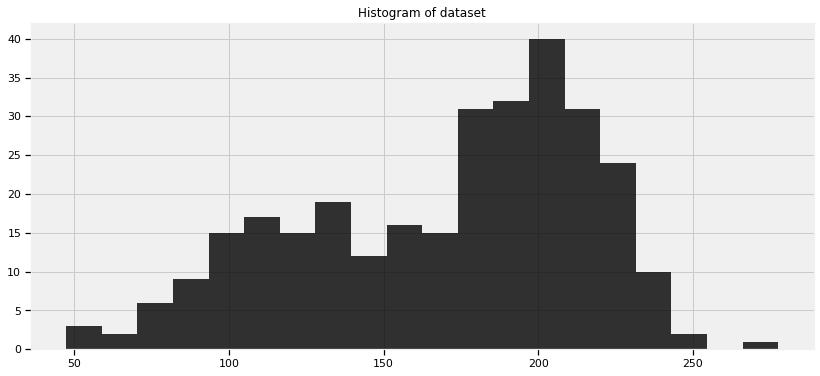

In [2]:
plt.figure(figsize=(12.5, 6))
data_ = np.loadtxt('mixture_data.csv', delimiter=',')

plt.hist(data_, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('Histogram of dataset')
plt.ylim([0, None]);
print(data_[:10], "...")

In [3]:
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])

rv_assignment = tfd.Categorical(name='assignment', probs=p)
assignment = rv_assignment.sample(sample_shape=data_.shape[0])

[
    p_,
    assignment_
] = evaluate([
    p,
    assignment
])

print('prior assignment, with p = %.2f:' % p_[0])
print(assignment_[:10])

prior assignment, with p = 0.20:
[1 1 1 1 1 1 0 1 1 1]


Looking at the above dataset, I would guess that the standard deviations of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of TFP code:
```python
rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
```
Here we are using a batch shape of 2, creating two independent distributions, that happen to have the same parameters. 

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. Their priors can be modelled by a Normal distribution. Looking at the data, I have an idea where the two centres might be - around 120 and 190, although I'm not very confident about these eyeballed estimates. Hence we'll set $\mu_0 = 120, \mu_1=90$ and $\sigma_0=\sigma_1=10.$

Finally, we use the [MixtureSameFamily](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily) distribution to implement a mixture of our two Normal distributions, employing our Categorical distribution as our selecting function.

In [4]:
rv_sds = tfd.Uniform(name='rv_sds', low=[0., 0.], high=[100., 100])
print(str(rv_sds))

rv_centers = tfd.Normal(name='rv_centers', loc=[120., 190.], scale=[10., 10.])

sds = rv_sds.sample()
print('shape of sds sample:', sds.shape)
centers = rv_centers.sample()

rv_assignments = tfd.Categorical(probs=tf.stack([0.4, 0.6]))
assignments = rv_assignments.sample(sample_shape=10)

# and to combine it with the observations:
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=rv_assignments,
    components_distribution=tfd.Normal(
        loc=centers,
        scale=sds))

observations = rv_observations.sample(sample_shape=10)

[
    assignments_,
    observations_,
    sds_,
    centers_
] = evaluate([
    assignments,
    observations,
    sds,
    centers
])

print('simulated data: ', observations_[:4], '...')
print('Random assignments: ', assignment_[:4], '...')
print('Assigned center: ', centers_[:4], '...')
print('Assigned standard deviation: ', sds_[:4], '...')

W0825 16:58:00.255883 4594435520 deprecation.py:323] From /Users/sueliu/projects/personal-study/Bayesian-Methods-for-Hackers/.venv/lib/python3.7/site-packages/tensorflow_probability/python/internal/distribution_util.py:493: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


tfp.distributions.Uniform("rv_sds/", batch_shape=[2], event_shape=[], dtype=float32)
shape of sds sample: (2,)
simulated data:  [186.66937 179.75722 175.12341 175.84259] ...
Random assignments:  [1 1 1 1] ...
Assigned center:  [106.61368 183.00447] ...
Assigned standard deviation:  [31.971836 12.497437] ...


Similarly, in the joint `log_prob` function below, we create two clusters each with our priors on the centers and standard deviations. Then we mix them in proportion to their weights as determined by our `Categorical` variable, creating a mixture of gaussians distribution. Finally, for each data point, we generate a sample from that mixture.

Note that this model is marginalizing out the cluster assignment variable, so that all the remaining random variables are continuous, making it all amenable to simple MCMC - `HamiltonianMonteCarlo` in particular.

In [5]:
def joint_log_prob(data_, sample_prob_1, sample_centers, sample_sds):
    """
    Joint log probability optimization function.
        
    Args:
      data: tensor array representation of original data
      sample_prob_1: Scalar representing probability (out of 1.0) of assignment 
        being 0
      sample_sds: 2d vector containing standard deviations for both normal dists
        in model
      sample_centers: 2d vector containing centers for both normal dists in model
    Returns: 
      Joint log probability optimization function.
    """  
    ### Create a mixture of two scalar Gaussians:
    rv_prob = tfd.Uniform(name='rv_prob', low=0., high=1.)
    sample_prob_2 = 1. - sample_prob_1
    rv_assignments = tfd.Categorical(probs=tf.stack([sample_prob_1, sample_prob_2]))
    
    rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
    rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.])
    
    rv_observations = tfd.MixtureSameFamily(
        mixture_distribution=rv_assignments,
        components_distribution=tfd.Normal(
          loc=sample_centers,       # One for each component.
          scale=sample_sds))        # And same here.
    return (
        rv_prob.log_prob(sample_prob_1)
        + rv_prob.log_prob(sample_prob_2)
        + tf.reduce_sum(rv_observations.log_prob(data_))      # Sum over samples.
        + tf.reduce_sum(rv_centers.log_prob(sample_centers)) # Sum over components.
        + tf.reduce_sum(rv_sds.log_prob(sample_sds))         # Sum over components.
    )


We will use our HMC sampling methods to explore the space by using 25000 sample iterations below.

In [16]:
number_of_steps=25000 #@param {type:"slider", min:0, max:50000, step:1000}
burnin=1000 #@param {type:"slider", min:0, max:2000, step:100}
num_leapfrog_steps=3

# Set the chain's start state.
initial_chain_state = [
    tf.constant(0.5, name='init_probs'),
    tf.constant([120., 190.], name='init_centers'),
    tf.constant([10., 10.], name='init_sds')
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(data_, *args)


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    
hmc = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=num_leapfrog_steps,
            step_size=step_size,
            state_gradients_are_stopped=True)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=int(burnin*0.8))

In [17]:
# Sample from the chain.
[
    posterior_prob,
    posterior_centers,
    posterior_sds
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr)

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [18]:
evaluate(kernel_results.inner_results.accepted_results.step_size)

array([0.05276433, 0.05276433, 0.05276433, ..., 0.05276433, 0.05276433,
       0.05276433], dtype=float32)

In [30]:
kernel_results.inner_results.inner_results.is_accepted

<tf.Tensor 'mcmc_sample_chain_2/trace_scan/TensorArrayStack_13/TensorArrayGatherV3:0' shape=(25000,) dtype=bool>

In [19]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_,
    posterior_centers_,
    posterior_sds_,
    kernel_results_
] = evaluate([
    posterior_prob,
    posterior_centers,
    posterior_sds,
    kernel_results
])
    
new_step_size_initializer_ = kernel_results_.inner_results.is_accepted.mean()
print("acceptance rate: {}".format(
    new_step_size_initializer_))

acceptance rate: 0.82276


In [22]:
kernel_results_.inner_results.accepted_results.step_size[-100:].mean()

0.05276433

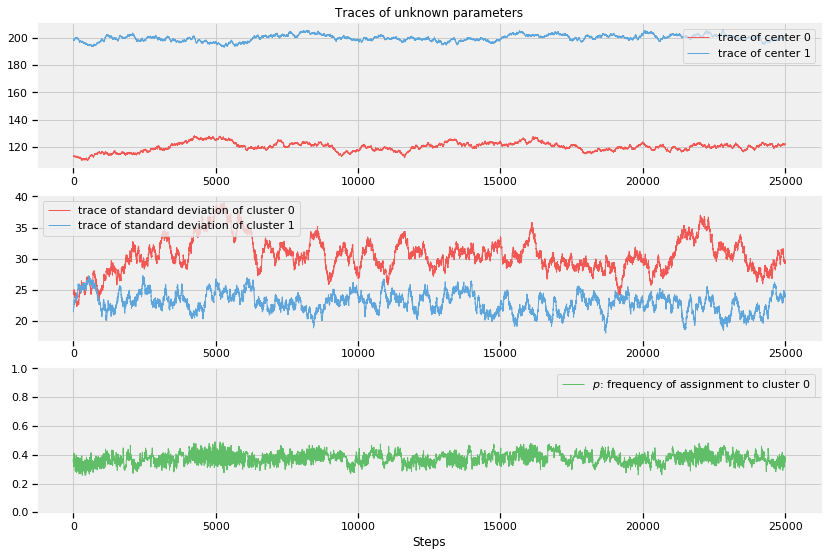

In [20]:
plt.figure(figsize(12.5, 9))
plt.subplot(311)
lw = 1
center_trace = posterior_centers_

# for pretty colors later in the book.
colors = [TFColor[3], TFColor[0]] if center_trace[-1, 0] > center_trace[-1, 1] \
    else [TFColor[0], TFColor[3]]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = posterior_sds_
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = posterior_prob_
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=TFColor[2], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

In [24]:
number_of_steps=50000
burnin=10000

# Set the chain's start date
initial_chain_state = [
    tf.constant(posterior_prob_[-1], name='init_probs_2'),
    tf.constant(posterior_centers_[-1], name='init_centers_2'),
    tf.constant(posterior_sds_[-1], name='init_sds_2')
]

# Initialize the step size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size_2',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        state_gradients_are_stopped=True)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=int(burnin*0.8))

# Sample from the chain.
[
    posterior_prob_2,
    posterior_centers_2,
    posterior_sds_2
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=adaptive_hmc)

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

evaluate(init_g)
evaluate(init_l)

[
    posterior_prob_2_,
    posterior_centers_2_,
    posterior_sds_2_,
    kernel_results_
] = evaluate([
    posterior_prob_2,
    posterior_centers_2,
    posterior_sds_2,
    kernel_results
])

print('acceptance rate: {}'.format(
    kernel_results_.inner_results.is_accepted.mean()))

print('final step size: {}'.format(
    kernel_results_.inner_results.accepted_results.step_size[-100:].mean()))

acceptance rate: 0.39296
final step size: 0.060651227831840515


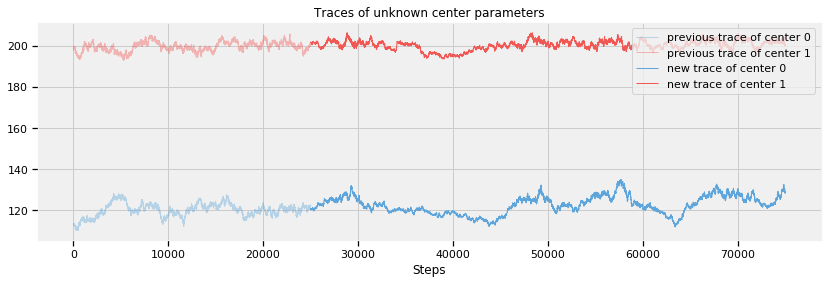

In [25]:
plt.figure(figsize(12.5, 4))
center_trace = posterior_centers_2_
prev_center_trace = posterior_centers_

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
      lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
      lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#5DA5DA")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#F15854")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

### Cluster Investigation

We have not forgotten our main challenge: identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

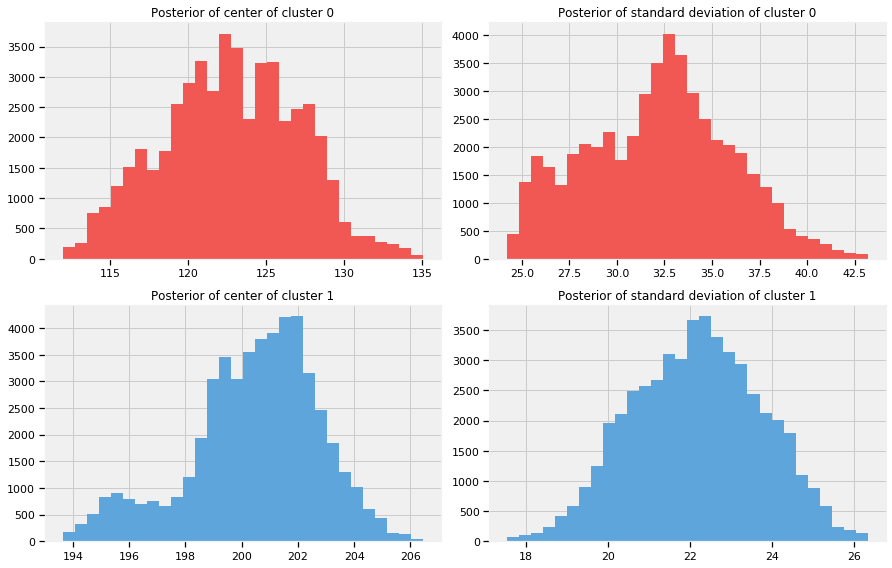

In [26]:
plt.figure(figsize=(12.5, 8))
std_trace = posterior_sds_2_
prev_std_trace = posterior_sds_

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title('Posterior of center of cluster %d' % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
            histtype='stepfilled')
    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title('Posterior of standard deviation of cluster %d' % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30, histtype='stepfilled')
    
plt.tight_layout()

We can generate a posterior predictive distribution over the assignments, and then generate some samples from it.

In [27]:
# Put the data into a tensor
data = tf.constant(data_, dtype=tf.float32)
data = data[:, tf.newaxis]

# This produces a cluster per MCMC chain
rv_clusters_1 = tfd.Normal(posterior_centers_2_[:, 0], posterior_sds_2_[:, 0])
rv_clusters_2 = tfd.Normal(posterior_centers_2_[:, 1], posterior_sds_2_[:, 1])

# Compute the un-normalized log probabilities for each cluster
cluster_1_log_prob = rv_clusters_1.log_prob(data) + tf.math.log(posterior_prob_2_)
cluster_2_log_prob = rv_clusters_2.log_prob(data) + tf.math.log(1. - posterior_prob_2_)

x = tf.stack([cluster_1_log_prob, cluster_2_log_prob], axis=-1)
y = tf.math.reduce_logsumexp(x, -1)

# Bayes rule to compute the assignment probability: 
# P(cluster = 1 |data) \prop P(data |cluster=1) P(cluster = 1)
log_p_assign_1 = cluster_1_log_prob - tf.math.reduce_logsumexp(tf.stack([cluster_1_log_prob, 
                                                                         cluster_2_log_prob], axis=-1), -1)

# Average across the MCMC chain
log_p_assign_1 = tf.math.reduce_logsumexp(log_p_assign_1, -1) - tf.math.log(tf.cast(
    log_p_assign_1.shape[-1], tf.float32))

p_assign_1 = tf.exp(log_p_assign_1)
p_assign = tf.stack([p_assign_1, 1-p_assign_1], axis=-1)

probs_assignment = p_assign_1

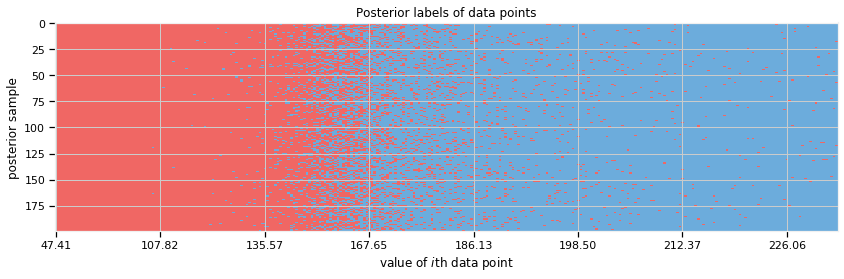

In [28]:
burned_assignment_trace_ = evaluate(tfd.Categorical(probs=p_assign).sample(sample_shape=200))
plt.figure(figsize(12.5, 5))
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(burned_assignment_trace_[:, np.argsort(data_)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data_.shape[0], 40),
       ["%.2f" % s for s in np.sort(data_)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

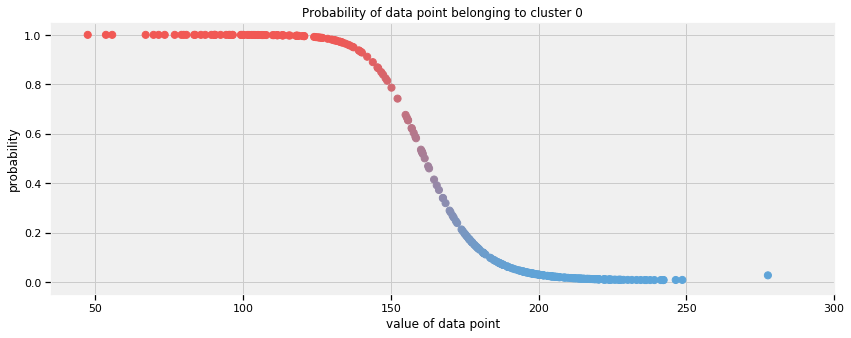

In [30]:
plt.figure(figsize(12.5, 5))

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = evaluate(probs_assignment)[np.argsort(data_)]
plt.scatter(data_[np.argsort(data_)], assign_trace, cmap=cmap,
        c=(1 - assign_trace), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

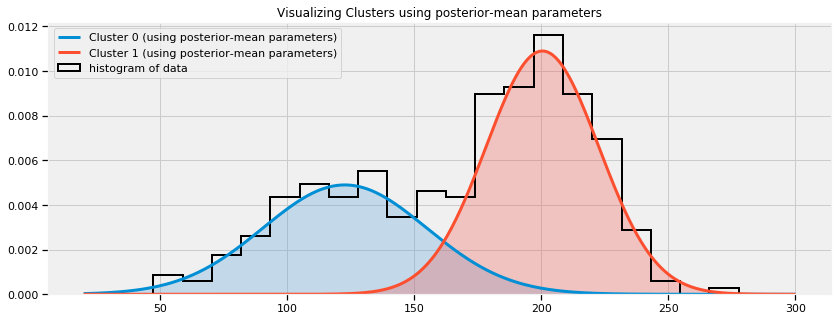

In [31]:
x_ = np.linspace(20, 300, 500)
posterior_center_means_ = evaluate(tf.reduce_mean(posterior_centers_2_, axis=0))
posterior_std_means_ = evaluate(tf.reduce_mean(posterior_sds_2_, axis=0))
posterior_prob_mean_ = evaluate(tf.reduce_mean(posterior_prob_2_, axis=0))

plt.hist(data_, bins=20, histtype="step", density=True, color="k",
     lw=2, label="histogram of data")
y_ = posterior_prob_mean_ * evaluate(tfd.Normal(loc=posterior_center_means_[0],
                                scale=posterior_std_means_[0]).prob(x_))
plt.plot(x_, y_, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x_, y_, color=colors[1], alpha=0.3)

y_ = (1 - posterior_prob_mean_) * evaluate(tfd.Normal(loc=posterior_center_means_[1],
                                      scale=posterior_std_means_[1]).prob(x_))
plt.plot(x_, y_, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x_, y_, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");